# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2022-09-20 00:46:57--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M  2.68MB/s    in 63s     

2022-09-20 00:48:01 (1.77 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [2]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [3]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255. # Min-max scaling

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

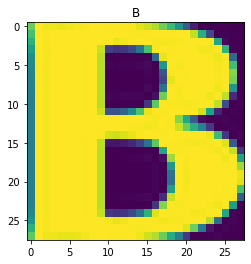

In [4]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18724)

plt.imshow(X[i,:,:,0])
plt.title("ABCDEFGHIJ"[y[i]]);

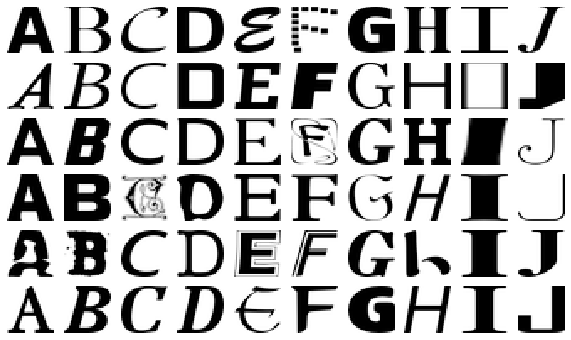

In [5]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [6]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [7]:
from tensorflow.keras.utils import to_categorical

n_class = len(np.unique(y_train))
y_train = to_categorical(y_train, n_class)

In [8]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979, 10))

# Keras를 이용한 모델링 훈련!

1. Flatten layer 활용
2. Hidden Layer 3개까지!
3. activation이 주어진 Dense layer뒤에 BatchNormalization 둬볼 것
4. Dropout을 0.2 정도로 활용해볼 것 (output layer 앞에 적용)
5. Early stopping도 활용해볼 것

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

In [15]:
keras.backend.clear_session()

il = Input(shape=(28, 28, 1))
fl = Flatten()(il)

hl = Dense(128, activation='relu')(fl)
bn = BatchNormalization()(hl)
hl = Dense(256, activation='relu')(bn)
bn = BatchNormalization()(hl)
hl = Dense(512, activation='relu')(bn)
bn = BatchNormalization()(hl)

do = Dropout(0.2)(bn)
ol = Dense(n_class, activation='softmax')(do)

model = keras.models.Model(il, ol)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                             

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

In [12]:
mcp = ModelCheckpoint(filepath='/content/model.ckpt',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,      # 가장 결과가 좋았던 내용만 저장
                      save_weights_only=False)   # True일 경우 모델 구조 X 가중치만 저장

In [16]:
model.fit(x_train, y_train, validation_split=0.2, callbacks=[es, mcp], verbose=1, epochs=100)

Epoch 1/100
373/375 [============================>.] - ETA: 0s - loss: 0.5726 - categorical_accuracy: 0.8367
Epoch 1: val_loss improved from inf to 0.44086, saving model to /content/model.ckpt
375/375 [==============================] - 7s 9ms/step - loss: 0.5718 - categorical_accuracy: 0.8369 - val_loss: 0.4409 - val_categorical_accuracy: 0.8762
Epoch 2/100
368/375 [============================>.] - ETA: 0s - loss: 0.3649 - categorical_accuracy: 0.8930
Epoch 2: val_loss improved from 0.44086 to 0.41603, saving model to /content/model.ckpt
375/375 [==============================] - 3s 8ms/step - loss: 0.3650 - categorical_accuracy: 0.8930 - val_loss: 0.4160 - val_categorical_accuracy: 0.8889
Epoch 3/100
371/375 [============================>.] - ETA: 0s - loss: 0.3090 - categorical_accuracy: 0.9069
Epoch 3: val_loss improved from 0.41603 to 0.39185, saving model to /content/model.ckpt
375/375 [==============================] - 3s 9ms/step - loss: 0.3096 - categorical_accuracy: 0.9068 - 